In [65]:
import pandas as pd
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup as bs4
import numpy as np
from datetime import time


# ETL Hechos homicidios

In [66]:
#abrimos el archivo de excel
homicidios=pd.read_excel('Datasets\homicidios.xlsx',sheet_name=None)

In [67]:
#observamos que hojas tiene para saber cuales necestiamos
homicidios.keys()

dict_keys(['HECHOS', 'DICCIONARIO_HECHOS', 'VICTIMAS', 'DICCIONARIO_VICTIMAS', 'clas'])

In [68]:
# se pasa a un dataframe a parte la hoja de hechos
dfhechos=homicidios['HECHOS']
dfhechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [69]:
dfhechos.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO'],
      dtype='object')

In [70]:
#revisamos todas las columnas para decidir si eliminamos algunas, o trabajmos con todas
dfhechos.drop(columns=['AAAA','MM','DD','Dirección Normalizada','XY (CABA)','PARTICIPANTES'],inplace=True)

In [71]:
dfhechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               696 non-null    object        
 1   N_VICTIMAS       696 non-null    int64         
 2   FECHA            696 non-null    datetime64[ns]
 3   HORA             696 non-null    object        
 4   HH               696 non-null    object        
 5   LUGAR_DEL_HECHO  696 non-null    object        
 6   TIPO_DE_CALLE    696 non-null    object        
 7   Calle            695 non-null    object        
 8   Altura           129 non-null    float64       
 9   Cruce            525 non-null    object        
 10  COMUNA           696 non-null    int64         
 11  pos x            696 non-null    object        
 12  pos y            696 non-null    object        
 13  VICTIMA          696 non-null    object        
 14  ACUSADO          696 non-null    object   

In [72]:
#comenzamos checando los nulos y duplicados
print(dfhechos.duplicated().sum())
print(dfhechos.isnull().sum())

0
ID                   0
N_VICTIMAS           0
FECHA                0
HORA                 0
HH                   0
LUGAR_DEL_HECHO      0
TIPO_DE_CALLE        0
Calle                1
Altura             567
Cruce              171
COMUNA               0
pos x                0
pos y                0
VICTIMA              0
ACUSADO              0
dtype: int64


In [73]:
# al abrir los primeros datos, observaos que donde falta la aaltura, en muchas fias falta el cruce,
# y que la suma de las dos faltantes es mayor al total de filas
print(f'Nulos en Altura: {dfhechos.Altura.isnull().sum()}       {dfhechos.Altura.isnull().sum()/len(dfhechos)*100} % de total\nNulos en Cruce: {dfhechos.Cruce.isnull().sum()}        {dfhechos.Cruce.isnull().sum()/len(dfhechos)*100} % de total\nSuma de los dos faltantes:  {dfhechos.Altura.isnull().sum()+dfhechos.Cruce.isnull().sum()}\nTotal de filas: {len(dfhechos)}                        \nDiferencia entre total de filas y total de faltantes de las columnas Altura y Cruce: {-len(dfhechos)+dfhechos.Altura.isnull().sum()+dfhechos.Cruce.isnull().sum()}')

Nulos en Altura: 567       81.46551724137932 % de total
Nulos en Cruce: 171        24.568965517241377 % de total
Suma de los dos faltantes:  738
Total de filas: 696                        
Diferencia entre total de filas y total de faltantes de las columnas Altura y Cruce: 42


In [74]:
dfhechos[['Altura','Cruce']][dfhechos.Altura.isnull()].head()

,Altura,Cruce
0,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV."
1,NaN,DE LOS CORRALES AV.
3,NaN,"VILLEGAS, CONRADO, GRAL."
4,NaN,"SAENZ PE?A, LUIS, PRES."
5,NaN,ESCALADA AV.


In [75]:
dfhechos[['Altura','Cruce']][dfhechos.Cruce.isnull()].head()

,Altura,Cruce
2,2034.0,NaN
9,1366.0,NaN
14,156.0,NaN
33,1483.0,NaN
35,NaN,NaN


In [76]:
ambosnulo=len(dfhechos[['Altura','Cruce']][(dfhechos.Cruce.isnull())&dfhechos.Altura.isnull()])
print('Filas donde la calle es nula y el cruce es nulo= ',ambosnulo)
dfhechos[(dfhechos.Cruce.isnull())&dfhechos.Altura.isnull()].head()

Filas donde la calle es nula y el cruce es nulo=  42


,ID,N_VICTIMAS,FECHA,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,COMUNA,pos x,pos y,VICTIMA,ACUSADO
35,2016-0049,1,2016-04-17,00:00:00,0,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI KM....,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,4,-58.37714647568196,-34.63657525428238,SD,SD
38,2016-0052,1,2016-04-20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NaN,NaN,13,.,.,MOTO,SD
64,2016-0087,1,2016-07-02,00:10:00,0,AUTOPISTA 1 SUR PTE ARTURO FRONDIZI Y AV CASEROS,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,1,-58.37864583,-34.62907067,MOTO,OBJETO FIJO
71,2016-0096,1,2016-07-25,07:00:00,7,"AUTOPISTA DELLEPIANE LUIS TTE. GRAL. KM. 2,3",AUTOPISTA,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.,NaN,NaN,8,-58.47433193007387,-34.66684950051973,MOTO,CARGAS
81,2016-0107,1,2016-08-20,08:22:00,8,AUTOPISTA 9 DE JULIO SUR ALT AV MENDOZA,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,4,-58.37157668,-34.65429986,MOTO,AUTO


Aqui podemos observar que cuando falta un dato en cruce, se presenta en altura, esto es porque no siempre se dan los accidnetes viales en la esquinas, y hay pocos datos donde em ambos son nulos que son el 5% del toal del dataframe, dado que la columna de cruce y altura, nos indican solamente en donde es mas probable un accidente, no se pueden retirar del dataframe.

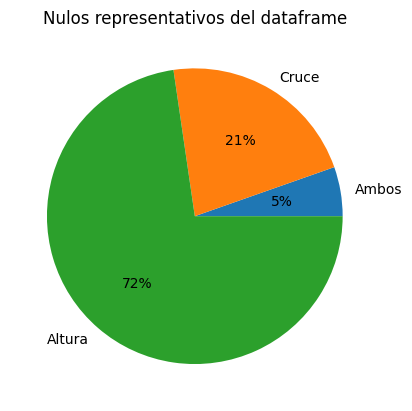

In [77]:
plt.pie(x=[ambosnulo,dfhechos.Cruce.isnull().sum(),dfhechos.Altura.isnull().sum()],labels=['Ambos','Cruce','Altura'],autopct='%d%%')
plt.title('Nulos representativos del dataframe')
plt.show()

In [78]:
#ccreamos una columna nueva, donde solo nos indique si el choque ocurrió en un cruce de calles o entre dos esquinas
# si no existe ninguno de los dos datos, se pone SD siguiendo el mismo patrón que tiene el dataset
dfhechos.loc[dfhechos.Altura.notnull(),'Cruce_o_Altura']='Altura'
dfhechos.loc[dfhechos.Cruce.notnull(),'Cruce_o_Altura']='Cruce'
dfhechos.Cruce_o_Altura.fillna('SD',inplace=True)
dfhechos.drop(columns=['Cruce','Altura'],inplace=True)
print('nulos restantes: ',dfhechos.isnull().sum())
dfhechos.head()

nulos restantes:  ID                 0
N_VICTIMAS         0
FECHA              0
HORA               0
HH                 0
LUGAR_DEL_HECHO    0
TIPO_DE_CALLE      0
Calle              1
COMUNA             0
pos x              0
pos y              0
VICTIMA            0
ACUSADO            0
Cruce_o_Altura     0
dtype: int64


,ID,N_VICTIMAS,FECHA,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,8,-58.47533969,-34.68757022,MOTO,AUTO,Cruce
1,2016-0002,1,2016-01-02,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",9,-58.50877521,-34.66977709,AUTO,PASAJEROS,Cruce
2,2016-0003,1,2016-01-03,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,1,-58.39040293,-34.63189362,MOTO,AUTO,Altura
3,2016-0004,1,2016-01-10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,8,-58.46503904,-34.68092974,MOTO,SD,Cruce
4,2016-0005,1,2016-01-21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,1,-58.38718297,-34.62246630,MOTO,PASAJEROS,Cruce


In [79]:
#observamos que esa fila con un nulo en calle no contiene datos relevantes, y el porcentaje que representa es muy bajo, por lo que se decide borrar
print(dfhechos[dfhechos.Calle.isnull()])
print(f'porcentaje que representa el nulo en Calle: {dfhechos.Calle.isnull().sum()/len(dfhechos)*100} %')
print('porcentaje sobre el total de accidentes del mismo año donde la calle es nulo: ',dfhechos.Calle.isnull().sum()/(dfhechos.FECHA.dt.year==dfhechos.FECHA[dfhechos.Calle.isnull()].dt.year.iloc[0]).sum()*100,'%')
dfhechos.dropna(subset='Calle',inplace=True)

            ID  N_VICTIMAS      FECHA      HORA  HH LUGAR_DEL_HECHO  \
119  2016-0151           1 2016-11-18  20:35:00  20              SD   

    TIPO_DE_CALLE Calle  COMUNA pos x pos y VICTIMA ACUSADO Cruce_o_Altura  
119         CALLE   NaN       0     .     .  PEATON      SD             SD  
porcentaje que representa el nulo en Calle: 0.14367816091954022 %
porcentaje sobre el total de accidentes del mismo año donde la calle es nulo:  0.6944444444444444 %


In [80]:
#procedemos a checar que ya no existan nulos
dfhechos.isnull().sum().sum()

0

In [81]:
dfhechos['HH']=dfhechos.HH.astype(str)
dfhechos['pos x']=dfhechos['pos x'].astype(str)
dfhechos['pos y']=dfhechos['pos y'].astype(str)

In [82]:
#quitamos las columnas de lugar del hecho, ya que  para fines de analsis no nos son relevantes, al ser muchos datos distintos, no nos arrojan un dato relevante
print('lugar del hecho únicos: ',len(dfhechos.LUGAR_DEL_HECHO.unique()))
dfhechos.drop(columns='LUGAR_DEL_HECHO',inplace=True)
dfhechos.head()

lugar del hecho únicos:  682


,ID,N_VICTIMAS,FECHA,HORA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,04:00:00,4,AVENIDA,PIEDRA BUENA AV.,8,-58.47533969,-34.68757022,MOTO,AUTO,Cruce
1,2016-0002,1,2016-01-02,01:15:00,1,GRAL PAZ,"PAZ, GRAL. AV.",9,-58.50877521,-34.66977709,AUTO,PASAJEROS,Cruce
2,2016-0003,1,2016-01-03,07:00:00,7,AVENIDA,ENTRE RIOS AV.,1,-58.39040293,-34.63189362,MOTO,AUTO,Altura
3,2016-0004,1,2016-01-10,00:00:00,0,AVENIDA,LARRAZABAL AV.,8,-58.46503904,-34.68092974,MOTO,SD,Cruce
4,2016-0005,1,2016-01-21,05:20:00,5,AVENIDA,SAN JUAN AV.,1,-58.38718297,-34.62246630,MOTO,PASAJEROS,Cruce


In [83]:
#cambiamos el formato de los datos, de mayusculas, a tener cada palabra la primer letra mayúscula
cols=dfhechos.select_dtypes(include='object').columns
stop_words=list(stopwords.words('spanish'))
for b in cols[cols!='HORA']:
    dfhechos[b]=dfhechos[b].apply(lambda x: ' '.join([a.capitalize() if a.lower() not in stop_words else a.lower() for a in x.split(' ')]))



In [84]:
dfhechos.head()

,ID,N_VICTIMAS,FECHA,HORA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,04:00:00,4,Avenida,Piedra Buena Av.,8,-58.47533969,-34.68757022,Moto,Auto,Cruce
1,2016-0002,1,2016-01-02,01:15:00,1,Gral Paz,"Paz, Gral. Av.",9,-58.50877521,-34.66977709,Auto,Pasajeros,Cruce
2,2016-0003,1,2016-01-03,07:00:00,7,Avenida,entre Rios Av.,1,-58.39040293,-34.63189362,Moto,Auto,Altura
3,2016-0004,1,2016-01-10,00:00:00,0,Avenida,Larrazabal Av.,8,-58.46503904,-34.68092974,Moto,Sd,Cruce
4,2016-0005,1,2016-01-21,05:20:00,5,Avenida,San Juan Av.,1,-58.38718297,-34.62246630,Moto,Pasajeros,Cruce


In [85]:
#observamos que hay filas donde no hay valor de coordenadas
print(dfhechos.COMUNA[(dfhechos['pos x'].str.len()<3)|(dfhechos['pos y'].str.len()<3)].count())

11


In [86]:
#sacamos de internet las coordenadas de las direcciones donde el dato no existe, el eje x y y estaban vacíos
#así nos pueden servir mas adelante para un mapa de calor, se les asigna las coordenadas de la comuna, para fines de geolocalización por comuna
#al no necesitar ubicación exacta
for a in dfhechos.COMUNA[(dfhechos['pos x'].str.len()<3)|(dfhechos['pos y'].str.len()<3)].unique():
    response=requests.get('https://es.wikipedia.org/wiki/Comuna_'+str(a)+'_(Ciudad_de_Buenos_Aires)')
    soup=bs4(response.text,'html.parser')
    try:
        long=str(soup.find('span',class_='longitude').text)
        lat=str(soup.find('span',class_='latitude').text)
    except:
        print('comuna con error: ',a)
        continue
    lat=lat.strip(' ')
    long=long.strip(' ')
    lat=lat.replace('°',',')
    lat=lat.replace('′',',')
    lat=lat.replace('″',',')
    long=long.replace('°',',')
    long=long.replace('′',',')
    long=long.replace('″',',')
    lat=lat.split(',')
    long=long.split(',')
    la=0
    if lat[-1] in ['O','S']:
        lat=(float(lat[0])+(float(lat[1])/60)+(float(lat[2])/3600))*-1
    if long[-1] in ['O','S']:
        long=(float(long[0])+(float(long[1])/60)+(float(long[2])/3600))*-1
    dfhechos.loc[(dfhechos['pos x'].str.len()<3)&(dfhechos.COMUNA==a),'pos x']=str(long)
    dfhechos.loc[(dfhechos['pos y'].str.len()<3)&(dfhechos.COMUNA==a),'pos y']=str(lat)
#Verificammos cuantas comunas dieron error
print(dfhechos.COMUNA[(dfhechos['pos x'].str.len()<3)|(dfhechos['pos y'].str.len()<3)].count())
#Al solo ser un dato del total de nuestros datos, no tendra mayor relevacia al hacer un mapa de calor

comuna con error:  0
1


In [87]:
dfhechos.head()

,ID,N_VICTIMAS,FECHA,HORA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,04:00:00,4,Avenida,Piedra Buena Av.,8,-58.47533969,-34.68757022,Moto,Auto,Cruce
1,2016-0002,1,2016-01-02,01:15:00,1,Gral Paz,"Paz, Gral. Av.",9,-58.50877521,-34.66977709,Auto,Pasajeros,Cruce
2,2016-0003,1,2016-01-03,07:00:00,7,Avenida,entre Rios Av.,1,-58.39040293,-34.63189362,Moto,Auto,Altura
3,2016-0004,1,2016-01-10,00:00:00,0,Avenida,Larrazabal Av.,8,-58.46503904,-34.68092974,Moto,Sd,Cruce
4,2016-0005,1,2016-01-21,05:20:00,5,Avenida,San Juan Av.,1,-58.38718297,-34.62246630,Moto,Pasajeros,Cruce


In [88]:
# checamos las columnas comuna, vcitima y acusado para bsucar datos unicos, atipicos, y vemos que en com,una hay uno que dice comuna 0
print(dfhechos.COMUNA.unique())
print(dfhechos.VICTIMA.unique())
print(dfhechos.ACUSADO.unique())

[ 8  9  1 11 15  4  7 12  3 13 14 10  6  2  5  0]
['Moto' 'Auto' 'Peaton' 'Sd' 'Cargas' 'Bicicleta' 'Pasajeros' 'Movil'
 'Objeto Fijo' 'Peaton_moto']
['Auto' 'Pasajeros' 'Sd' 'Objeto Fijo' 'Cargas' 'Moto' 'Multiple' 'otro'
 'Bicicleta' 'Tren']


In [89]:
#cheCAR ESTE DATO MAÑANA
dfhechos[dfhechos.COMUNA==0]

,ID,N_VICTIMAS,FECHA,HORA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
139,2016-0174,1,2016-12-27,00:00:00,0,Autopista,Autopista 25 de Mayo,0,.,.,Sd,Sd,Sd


In [90]:
#ahora vamos a cambiar primero los nombres de las columnas a modo que tengas la primer letra mayúscula
columnas=dfhechos.columns
cols={}
for a in dfhechos.columns:
    cols[a]=a.capitalize()
dfhechos.rename(columns=cols,inplace=True)
dfhechos.rename(columns={'N_victimas':'No_víctimas','Victima':'Víctimas','Hh':'Hora','Pos y':'Y','Pos x':'X','Hora':'Hora_formato'},inplace=True)
dfhechos.columns

Index(['Id', 'No_víctimas', 'Fecha', 'Hora_formato', 'Hora', 'Tipo_de_calle',
       'Calle', 'Comuna', 'X', 'Y', 'Víctimas', 'Acusado', 'Cruce_o_altura'],
      dtype='object')

In [91]:
dfhechos.head()

,Id,No_víctimas,Fecha,Hora_formato,Hora,Tipo_de_calle,Calle,Comuna,X,Y,Víctimas,Acusado,Cruce_o_altura
0,2016-0001,1,2016-01-01,04:00:00,4,Avenida,Piedra Buena Av.,8,-58.47533969,-34.68757022,Moto,Auto,Cruce
1,2016-0002,1,2016-01-02,01:15:00,1,Gral Paz,"Paz, Gral. Av.",9,-58.50877521,-34.66977709,Auto,Pasajeros,Cruce
2,2016-0003,1,2016-01-03,07:00:00,7,Avenida,entre Rios Av.,1,-58.39040293,-34.63189362,Moto,Auto,Altura
3,2016-0004,1,2016-01-10,00:00:00,0,Avenida,Larrazabal Av.,8,-58.46503904,-34.68092974,Moto,Sd,Cruce
4,2016-0005,1,2016-01-21,05:20:00,5,Avenida,San Juan Av.,1,-58.38718297,-34.62246630,Moto,Pasajeros,Cruce


In [92]:
dfhechos.to_csv('Datasets/homicidios_hechos.csv',index=False)

# ETL homicidios Víctimas

In [93]:
dfvictimas=homicidios['VICTIMAS']
dfvictimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


In [94]:
dfvictimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [95]:
#primero checaremos si hay nulos o duplicados
print('Nulos: ',dfvictimas.isnull().sum().sum())
print('Duplicados: ',dfvictimas.duplicated().sum())


Nulos:  0
Duplicados:  0


In [96]:
#verificamos si hay duplicados en el id, para verificar la integridad de esta columna
print('duplicados: ',dfvictimas.ID_hecho.duplicated().sum())
#checamos esad filas duplicadas con sus originales
duplicados=dfvictimas[dfvictimas.ID_hecho.duplicated()].ID_hecho.tolist()
dfvictimas[dfvictimas.ID_hecho.isin(duplicados)]
#al comprobar los datos, vemos que  no se trartan de valores duplicados, sino que las filas representan un mismo evento, donde se enlistan a varios tipos de rol de un mismo evento

duplicados:  21


,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
29,2016-0041,2016-03-29,2016,3,29,CONDUCTOR,MOTO,MASCULINO,54,2016-03-29 00:00:00
30,2016-0041,2016-03-29,2016,3,29,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,SD,2016-03-30 00:00:00
98,2016-0126,2016-09-18,2016,9,18,CONDUCTOR,AUTO,MASCULINO,37,SD
99,2016-0126,2016-09-18,2016,9,18,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,60,SD
163,2017-0026,2017-02-26,2017,2,26,PASAJERO_ACOMPAÑANTE,AUTO,FEMENINO,23,2017-02-26 00:00:00
164,2017-0026,2017-02-26,2017,2,26,CONDUCTOR,AUTO,MASCULINO,19,2017-02-26 00:00:00
173,2017-0035,2017-03-23,2017,3,23,CONDUCTOR,AUTO,MASCULINO,28,2017-03-23 00:00:00
174,2017-0035,2017-03-23,2017,3,23,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,32,2017-03-23 00:00:00
175,2017-0035,2017-03-23,2017,3,23,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,30,2017-03-23 00:00:00
176,2017-0036,2017-03-29,2017,3,29,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,SD,2017-03-29 00:00:00


In [97]:
cols=['ROL','VICTIMA','SEXO']
stop_words=list(stopwords.words('spanish'))
for b in cols:
    dfvictimas[b]=dfvictimas[b].apply(lambda x: ' '.join([a.capitalize() if a.lower() not in stop_words else a.lower() for a in x.split(' ')]))
dfvictimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,Conductor,Moto,Masculino,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,Conductor,Auto,Masculino,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,Conductor,Moto,Masculino,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,Conductor,Moto,Masculino,18,SD
4,2016-0005,2016-01-21,2016,1,21,Conductor,Moto,Masculino,29,2016-02-01 00:00:00


In [98]:
#quitamos las columnas que no necesitamos
dfvictimas.drop(columns=['AAAA','MM','DD'],inplace=True)

In [99]:
dfvictimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   ROL                  717 non-null    object        
 3   VICTIMA              717 non-null    object        
 4   SEXO                 717 non-null    object        
 5   EDAD                 717 non-null    object        
 6   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 39.3+ KB


In [100]:
df1=pd.to_datetime(dfvictimas.loc[dfvictimas['FECHA_FALLECIMIENTO']!='SD','FECHA_FALLECIMIENTO'])-pd.to_datetime(dfvictimas.loc[dfvictimas['FECHA_FALLECIMIENTO']!='SD','FECHA'])
dfvictimas.loc[dfvictimas['FECHA_FALLECIMIENTO']!='SD','Días_de_muerte_post_accidente']=df1.dt.days
dfvictimas.loc[dfvictimas['Días_de_muerte_post_accidente'].notnull(),'Días_de_muerte_post_accidente']=dfvictimas.loc[dfvictimas['Días_de_muerte_post_accidente'].notnull(),'Días_de_muerte_post_accidente'].astype(int)
dfvictimas['Días_de_muerte_post_accidente'].fillna('Sd',inplace=True)
dfvictimas.drop(columns='FECHA_FALLECIMIENTO',inplace=True)
dfvictimas.head()

,ID_hecho,FECHA,ROL,VICTIMA,SEXO,EDAD,Días_de_muerte_post_accidente
0,2016-0001,2016-01-01,Conductor,Moto,Masculino,19,0.0
1,2016-0002,2016-01-02,Conductor,Auto,Masculino,70,0.0
2,2016-0003,2016-01-03,Conductor,Moto,Masculino,30,0.0
3,2016-0004,2016-01-10,Conductor,Moto,Masculino,18,Sd
4,2016-0005,2016-01-21,Conductor,Moto,Masculino,29,11.0


In [101]:
#ahora vamos a cambiar primero los nombres de las columnas a modo que tengas la primer letra mayúscula
cols={}
for a in dfvictimas.columns:
    cols[a]=a.capitalize()
dfvictimas.rename(columns=cols,inplace=True)
dfvictimas.rename(columns={'Victima':'Víctima'},inplace=True)
dfvictimas.columns

Index(['Id_hecho', 'Fecha', 'Rol', 'Víctima', 'Sexo', 'Edad',
       'Días_de_muerte_post_accidente'],
      dtype='object')

In [102]:
#quitamos la columna Fecha, ya que en el primer dataframe existe ya ese dato
dfvictimas.drop(columns='Fecha',inplace=True)
dfvictimas.columns

Index(['Id_hecho', 'Rol', 'Víctima', 'Sexo', 'Edad',
       'Días_de_muerte_post_accidente'],
      dtype='object')

In [103]:
#cambiamos en kla columna edad SD por Sd, para tener todos nuestros datos en un mismo formato
dfvictimas.loc[dfvictimas.Edad=='SD','Edad']='Sd'
dfvictimas.Edad.unique()

array([19, 70, 30, 18, 29, 22, 16, 59, 65, 34, 41, 50, 38, 21, 52, 36, 20,
       54, 'Sd', 56, 24, 78, 79, 26, 57, 37, 58, 23, 60, 42, 53, 51, 40,
       87, 76, 75, 35, 80, 43, 45, 67, 27, 55, 49, 81, 25, 33, 46, 83, 39,
       28, 7, 48, 4, 82, 32, 17, 47, 61, 10, 95, 73, 84, 66, 85, 1, 15,
       13, 77, 44, 31, 62, 74, 71, 11, 86, 69, 72, 12, 63, 92, 68, 91, 64,
       5, 88], dtype=object)

In [104]:
#guardamos en un csv, para tener un respaldo
dfvictimas.to_csv('Datasets/homicidios_victimas.csv',index=False)

In [105]:
#juntamos las dos tablas, en un solo datatset, para tener toda la informacíon pertinente en un solo Dataframe, al no ser una fuente de datos enorme, no es necesario normalizar las tablas
dfhomicidios=dfvictimas.merge(dfhechos,how='left',left_on='Id_hecho',right_on='Id')
# se quita la columna id, ya que ya tenemos una con ese dato
dfhomicidios.drop('Id',inplace=True,axis=1)
dfhomicidios.rename(columns={'Id_hecho':'Id'},inplace=True)
dfhomicidios.head()

,Id,Rol,Víctima,Sexo,Edad,Días_de_muerte_post_accidente,No_víctimas,Fecha,Hora_formato,Hora,Tipo_de_calle,Calle,Comuna,X,Y,Víctimas,Acusado,Cruce_o_altura
0,2016-0001,Conductor,Moto,Masculino,19,0.0,1.0,2016-01-01,04:00:00,4,Avenida,Piedra Buena Av.,8.0,-58.47533969,-34.68757022,Moto,Auto,Cruce
1,2016-0002,Conductor,Auto,Masculino,70,0.0,1.0,2016-01-02,01:15:00,1,Gral Paz,"Paz, Gral. Av.",9.0,-58.50877521,-34.66977709,Auto,Pasajeros,Cruce
2,2016-0003,Conductor,Moto,Masculino,30,0.0,1.0,2016-01-03,07:00:00,7,Avenida,entre Rios Av.,1.0,-58.39040293,-34.63189362,Moto,Auto,Altura
3,2016-0004,Conductor,Moto,Masculino,18,Sd,1.0,2016-01-10,00:00:00,0,Avenida,Larrazabal Av.,8.0,-58.46503904,-34.68092974,Moto,Sd,Cruce
4,2016-0005,Conductor,Moto,Masculino,29,11.0,1.0,2016-01-21,05:20:00,5,Avenida,San Juan Av.,1.0,-58.38718297,-34.62246630,Moto,Pasajeros,Cruce


In [106]:
#observamos que hay una fila que no existía en los dos dataframes, simplemente rellenaremos con Sd como se ha trabajado
print('datos nulos: ' ,dfhomicidios.isnull().sum(),'\n')
dfhomicidios.fillna('Sd',inplace=True)
dfhomicidios.loc[dfhomicidios.X=='Sd',['X','Y']]='.'
print('datos nulos: ' ,dfhomicidios.isnull().sum())

datos nulos:  Id                               0
Rol                              0
Víctima                          0
Sexo                             0
Edad                             0
Días_de_muerte_post_accidente    0
No_víctimas                      1
Fecha                            1
Hora_formato                     1
Hora                             1
Tipo_de_calle                    1
Calle                            1
Comuna                           1
X                                1
Y                                1
Víctimas                         1
Acusado                          1
Cruce_o_altura                   1
dtype: int64 

datos nulos:  Id                               0
Rol                              0
Víctima                          0
Sexo                             0
Edad                             0
Días_de_muerte_post_accidente    0
No_víctimas                      0
Fecha                            0
Hora_formato                     0
Hora        

In [107]:
dfhomicidios.drop(index=dfhomicidios[dfhomicidios.No_víctimas=='Sd'].index,inplace=True)

In [108]:
# corregimos unos campos que fueron saliendo durante la realización del EDa y del dashboard
dfhomicidios.loc[dfhomicidios['Víctima']=='Movil','Víctima']='Auto'
dfhomicidios.drop(columns='Víctimas',inplace=True)


In [109]:
#se cambia por valores NA para el EDA
dfhomicidios[dfhomicidios=='Sd']=pd.NA
dfhomicidios[dfhomicidios=='SD']=pd.NA

In [110]:
dfhomicidios.isna().sum()

Id                                0
Rol                              11
Víctima                           9
Sexo                              5
Edad                             52
Días_de_muerte_post_accidente    67
No_víctimas                       0
Fecha                             0
Hora_formato                      1
Hora                              1
Tipo_de_calle                     0
Calle                             0
Comuna                            0
X                                 0
Y                                 0
Acusado                          22
Cruce_o_altura                   43
dtype: int64

In [111]:
#cambiamos a formato de fecha y la hora a int
dfhomicidios.Fecha=(pd.to_datetime(dfhomicidios.Fecha))
dfhomicidios.Hora=dfhomicidios.Hora.astype(int,errors='ignore')

In [112]:
#cambiamos la av gral paz a autopista, ya que asi está clasifacada en una pagina de buenos aires
dfhomicidios.loc[dfhomicidios.Tipo_de_calle=='Gral Paz','Tipo_de_calle']='Autopista'
dfhomicidios.drop(index=dfhomicidios[dfhomicidios.Comuna==0].index,inplace=True)

In [113]:
# existan filas que incluyen la fecha, vamos a dejar solo la hora
dfhomicidios.Hora_formato=dfhomicidios.Hora_formato.astype(str)
dfhomicidios.Hora_formato=dfhomicidios.Hora_formato.apply(lambda x: x.split(' ')[-1] )


In [114]:
# creamos una columna con rangos de edades
def rangos_edad(edad):
    if type(edad)==int:
        if edad<=18:
            return '0 a 18 años'
        if edad<=35:
            return '19 a 35 años'
        if edad<=50:
            return '36 a 50 años'
        if edad<=65:
            return '51 a 65 años'
        if edad>65:
            return 'mayor a 65 años'
        
dfhomicidios['Rango_edad']=dfhomicidios.Edad.apply(rangos_edad)
dfhomicidios['Rango_edad'].fillna('Desconcido',inplace=True)
dfhomicidios.Rango_edad.unique()

array(['19 a 35 años', 'mayor a 65 años', '0 a 18 años', '51 a 65 años',
       '36 a 50 años', 'Desconcido'], dtype=object)

In [115]:
#guardamos en un csv para su uso en el EDa y en el dashboard
dfhomicidios.to_csv('Datasets/homicidios.csv',index=False)


### TABLA COMUNAS

In [116]:
# Creamos una tabla donde se agrupan todas las victimas por comuna
comunas=dfhomicidios.groupby('Comuna')['No_víctimas'].count().reset_index()

In [117]:
# de la página de wikipedia, descargamos la geolocalización de todas las comuas, para usarlas como referencia en el dashboard
for a in comunas.Comuna.unique():
    response=requests.get('https://es.wikipedia.org/wiki/Comuna_'+str(int(a))+'_(Ciudad_de_Buenos_Aires)')
    soup=bs4(response.text,'html.parser')
    try:
        long=str(soup.find('span',class_='longitude').text)
        lat=str(soup.find('span',class_='latitude').text)
    except:
        print('comuna con error: ',a)
        continue
    lat=lat.strip(' ')
    long=long.strip(' ')
    lat=lat.replace('°',',')
    lat=lat.replace('′',',')
    lat=lat.replace('″',',')
    long=long.replace('°',',')
    long=long.replace('′',',')
    long=long.replace('″',',')
    lat=lat.split(',')
    long=long.split(',')
    la=0
    if lat[-1] in ['O','S']:
        lat=(float(lat[0])+(float(lat[1])/60)+(float(lat[2])/3600))*-1
    if long[-1] in ['O','S']:
        long=(float(long[0])+(float(long[1])/60)+(float(long[2])/3600))*-1
    comunas.loc[comunas.Comuna==a,'x']=str(long)
    comunas.loc[comunas.Comuna==a,'y']=str(lat)

In [118]:
comunas.to_csv('Datasets/comunas.csv',index=False)